# Intraretinal cyst fluid detection using Deep Learning

*Abstract— This work aims to do an experimental analysis of recent state of the art deep learning algorithms to find three retinal fluid types, with annotated images provided by two clinical centers, which were acquired with the three most common [OCT] https://en.wikipedia.org/wiki/Optical_coherence_tomography) device vendors from
patients with two different retinal diseases*.  

The rest of the project can be found on the [intraretinal-cyst-fluid-detection](project https://github.com/gabrielraya/intraretinal-cyst-fluid-detection) repository on Github.


## Overview

This is a introductory notebook to undertand the problem of cyst fluid detection, for this we are going to implement and apply some basic image processing techniques to first get familiar with the medical imaging data this project uses.


We will implement the following techniques:
1. conversion of raw mammography data into a gray-scale / color image
2. Split the data
3. Batch data creation

## Libraries

First, we import the basic libraries necessary to develop this assignment. Feel free to include more libraries if needed.


In [2]:
# First make sure you have install these two libraries:
!pip install SimpleITK
!pip install -U pydicom

     |████████████████████████████████| 42.5MB 1.5MB/s 
     |████████████████████████████████| 7.0MB 8.3MB/s 


In [0]:
import requests
import zipfile
from tqdm import tnrange, tqdm_notebook
import os
import SimpleITK as sitk
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
import numpy as np
from PIL import Image
import pydicom as dicom
from IPython import display
import time
from mpl_toolkits.mplot3d import Axes3D
import copy
matplotlib.rcParams['figure.figsize'] = [8, 6]
import scipy.signal

## Data

This notebook has been prepared to work directly from Colab but you can also work from any other resource.  The next cells import the data from the drive team folder, but you can also directly download the zip file from  [drive](https://drive.google.com/open?id=1Y2XKig36mh2WuJ-1ArJWoF-tlgKp8UnT).  To do so, you need to give Colab acces to your drive account.

In [4]:
# Only run this code when using Colab
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Define the path where data is stored

In [0]:
# DATA_FOLDER = './cyst_segmentation_ISMI_training_set/'                                  # Local System
DATA_FOLDER = 'gdrive/Team Drives/ISMI-FinalProject/cyst_segmentation_ISMI_training_set/' # Colab

In [6]:
!ls 'gdrive/Team Drives/ISMI-FinalProject/cyst_segmentation_ISMI_training_set/'
#'./cyst_segmentation_ISMI_training_set'

annotations  data_usage_policy.pdf  images


Check that the data folder contains the following structure:
````
cyst_segmentation_ISMI_training_set
  |-images
    |-pat001_im001.mdh
    |-pat001_im001.raw
    |-...
  |-annotations
    |-pat001_im001.mhd
    |-pat001_im001.zraw
    |-...
````

##  Data Inspection

This first part consists in reconstructing the given images from the raw data acquired with the tommoography machine. There are several steps that have to be applied to reconstruct a gray-scale / color image that can actually be read by radiologists with the aim of detecting these three type of fluids in the retina.

##1. Image transformation of eye tomography

### Read image

In your  data folder, you can find a file containing raw mammography data. Our goal is to do a good job at deriving a gray-level/color image from raw data.
The files are in ITK format, with extension ````.mhd````, and can be opened using the library ````SimpleITK````. You can find documentation on ````SimpleITK```` at this link: http://www.simpleitk.org/SimpleITK/help/documentation.html.
In the next cell, we provide the function used to read the raw data and the gray-level/color images.
Please refere to [SimpleITK conventions](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/03_Image_Details.html) to understand the images atttributes/conventions used by SimpleITK.

In [7]:
# raw data in ITK format
raw_img_filename = os.path.join(DATA_FOLDER,'images/pat001_im001.mhd')
out_img_filename = os.path.join(DATA_FOLDER,'annotations/pat001_im001.mhd')

# read ITK files using SimpleITK
raw_img = sitk.ReadImage(raw_img_filename)
out_img = sitk.ReadImage(out_img_filename)

# print image information
print('image size: {}'.format(raw_img.GetSize()))
print('image origin: {}'.format(raw_img.GetOrigin()))
print('image spacing: {}'.format(raw_img.GetSpacing()))
print('image width: {}'.format(raw_img.GetWidth()))
print('image height: {}'.format(raw_img.GetHeight()))
print('image depth: {}'.format(raw_img.GetDepth()))

image size: (508, 496, 18)
image origin: (1.3379, 0.00585, 2.70800000219485)
image spacing: (0.011500000022351742, 0.0038999998942017555, 0.24135294556617737)
image width: 508
image height: 496
image depth: 18


*the resolution of the image is 508x496  px, which give a total of <b>251968</b> pixeles. 
This image conttains 18 slides we can use to detect the cyst*

### Convert ITK image to Numpy array

In order to easily manipulate data, it is convenient to convert it into a numpy format, which can be transformed using the numpy library, and can easily be visualized using the ````pylab/matplotlib```` library.
Please check the documentation in http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/01_Image_Basics.html to find the proper function to transform the SimpleITK image to numpy. Write your code below:
* ````out_np````: should contain the numpy array from ````out_img````
* ````raw_np````: should contain the numpy array from ````raw_img````

Note: If you are not familiar with Numpy, you can check briefly this tutorial: http://cs231n.github.io/python-numpy-tutorial/

In [0]:
# convert the ITK image into numpy format
out_np = sitk.GetArrayFromImage(out_img)
raw_np = sitk.GetArrayFromImage(raw_img)

In [0]:
matplotlib.rcParams['figure.figsize'] = [8, 6]

In [10]:
# check shape of 1st array 
out_np[0].shape

(496, 508)

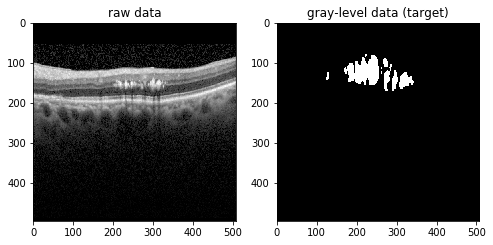

In [11]:
assert(out_np is not None),"out_np cannot be None"
assert(raw_np is not None),"raw_np cannot be None"

# visualize the two numpy arrays
plt.subplot(1,2,1)
plt.imshow(raw_np[0], cmap='gray')
plt.title('raw data')
plt.subplot(1,2,2)
plt.imshow(out_np[11], cmap='gray')
plt.title('gray-level data (target)')
plt.show()

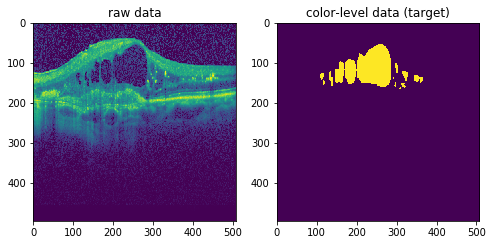

In [12]:
assert(out_np is not None),"out_np cannot be None"
assert(raw_np is not None),"raw_np cannot be None"

# visualize the two numpy arrays
plt.subplot(1,2,1)
plt.imshow(raw_np[10])
plt.title('raw data')
plt.subplot(1,2,2)
plt.imshow(out_np[10])
plt.title('color-level data (target)')
plt.show()

### Read the comple RETOUCH dataset

In [0]:
def get_file_list(path, ext=''):
    return sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith(ext)])

def load_img(path):
    return sitk.GetArrayFromImage(sitk.ReadImage(path))

**This process might take some time** : Please, be patient. This is reading the 112 volumentric with their n-corresponding B scans.

In [0]:
# get path names list of raw data in ITK format
x_img_files = get_file_list(os.path.join(DATA_FOLDER,'images/'), 'mhd')
y_img_files = get_file_list(os.path.join(DATA_FOLDER,'annotations/'), 'mhd')


# read ITK files using SimpleITK and conver then into a list of numpy arrays
X = [load_img(f) for f in x_img_files]
Y = [load_img(f) for f in y_img_files]

Let's verify the number of X sample files is the same as the number of annotated images Ys.

In [18]:
print("Number of list files X:{} , Y:{}".format(len(x_img_files),len(y_img_files)))
print("Number of samples X:{} , Y:{}".format(len(X),len(Y)))

Number of list files X:122 , Y:122
Number of samples X:122 , Y:122


In [19]:
# Test
print(x_img_files[0])
raw_np =  sitk.GetArrayFromImage(sitk.ReadImage(x_img_files[0]))
print(raw_np.shape)

gdrive/Team Drives/ISMI-FinalProject/cyst_segmentation_ISMI_training_set/images/pat001_im001.mhd
(18, 496, 508)


In [30]:
X[0].shape

(18, 496, 508)

In [0]:
b_scans = np.zeros(len(X))
w,h =np.zeros(len(X)), np.zeros(len(X))

In [0]:
# Plot histogram
b_scans = np.zeros(len(X))
w,h =np.zeros(len(X)), np.zeros(len(X))
for i in range(len(X)):
    b_scans[i],w[i],h[i]=(X[i].shape)

In [49]:
import pandas as pd
df = pd.DataFrame({'scans':b_scans,'h':h, 'w':w,})
df.head()

,scans,w,h
0,18.0,496.0,508.0
1,36.0,496.0,512.0
2,36.0,496.0,508.0
3,36.0,496.0,516.0
4,36.0,496.0,530.0


In [50]:
df.describe()

,scans,w,h
count,122.000000,122.0,122.000000
mean,30.090164,496.0,520.827869
std,8.806463,0.0,58.310042
min,14.000000,496.0,463.000000
25%,18.000000,496.0,499.000000
50%,36.000000,496.0,508.000000
75%,36.000000,496.0,516.000000
max,48.000000,496.0,788.000000


### Show a histogram of the b-scans distribution

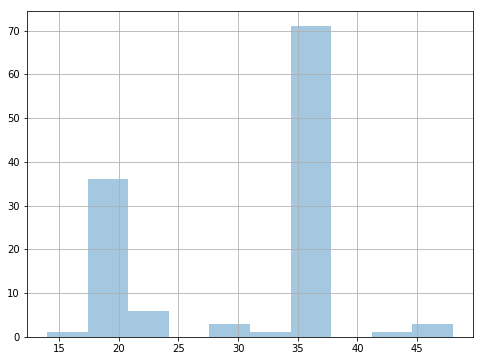

In [82]:
df.scans.hist(alpha=0.4)

In [71]:
#df.scans.unique()
from collections import Counter
Counter(b_scans)

Counter({14.0: 1,
         18.0: 36,
         22.0: 1,
         24.0: 5,
         30.0: 3,
         34.0: 1,
         36.0: 70,
         37.0: 1,
         42.0: 1,
         48.0: 3})

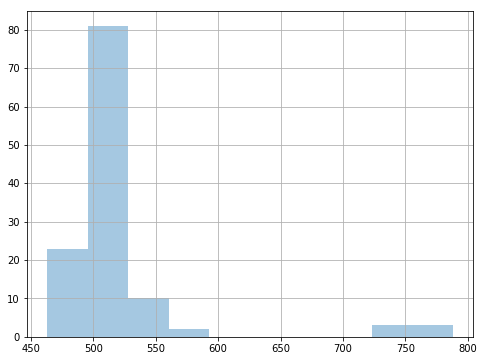

In [83]:
df.h.hist(alpha=0.4)

In [0]:
def show_image(img, lbl):
    matplotlib.rcParams['figure.figsize'] = (10, 6)
    s, h, w = img.shape 
    for i in range(s):
        plt.subplot(1,2,1)
        plt.imshow(img[i])
        plt.title('RGB image')

        plt.subplot(1,2,2)
        plt.imshow(lbl[i])
        plt.title('Manual annotation')
        plt.show()

In [0]:
i = 119# Try some values here    
show_image(X[i], Y[i])

Output hidden; open in https://colab.research.google.com to view.

In [0]:
class DataSet:
    
    def __init__(self, imgs, lbls=None):
        self.imgs = imgs
        self.lbls = lbls
    
    def get_lenght(self):
        return len(self.imgs)
    
    def show_image(self, i):
        if self.lbls != None:
            f, axes   = plt.subplots(1, 2)
            img_slice = self.imgs[i]
            lbls_slice= self.lbls[i]
            s = img_slice.shape[0]
            for ax, im, t in zip(axes, 
                                 (img_slice[i], lbls_slice[i]), 
                                 ('RGB image', 
                                  'Manual annotation; Range: [{}, {}]'.format(self.lbls[i].min(), 
                                                                              self.lbls[i].max()))):
                ax.imshow(im)
                ax.set_title(t)
        else:
            plt.imshow(self.imgs[i])
            plt.title('RGB image')
        plt.show()
        
        


Images in the training set are currently in the same order as read from disk. To avoid any bias possibly introduced by this order, it is always good to shuffle the training dataset. Note that images and annotations must be shuffled in the same way!

In [0]:
import random
# shuffle order of training images and manual annotations
indexes = list(range(len(X)))
random.shuffle(indexes)
indexes

train_imgs = list(np.asarray(X)[indexes])
train_lbls = list(np.asarray(Y)[indexes])

In [0]:
train_imgs[0].shape

(18, 496, 508)

In [0]:
len(train_imgs)

122

### Split into training and validation set
Now we can define a training and a validation set by using the Dataset class that we have defined. In order to define a validation set, you have to specify a coefficient (from 0 to 1) to indicate the percentage of training images that you want to use for validation (we have seen that typical splits are 70/30, 80/20 etc.

In [0]:
validation_percent = 0.2 # coefficient to define validation dataset (value between 0 and 1)

In [0]:
n_validation_imgs = int(validation_percent * len(train_imgs))

# use the first images as validation
validation_dataset = DataSet(train_imgs[:n_validation_imgs], train_lbls[:n_validation_imgs])

# the rest as training
training_dataset = DataSet(train_imgs[n_validation_imgs:], train_lbls[n_validation_imgs:])

# test dataset
#test_dataset = DataSet(test_imgs)

n_tra_imgs = training_dataset.get_lenght()
n_val_imgs = validation_dataset.get_lenght()
#n_tes_imgs = test_dataset.get_lenght()

print('{} training images'.format(n_tra_imgs))
print('{} validation images'.format(n_val_imgs))
#print('{} test images'.format(n_tes_imgs))

98 training images
24 validation images


### Visualize datasets
Let's visualize images in the training, the validation and the test set.

In [0]:
# training set
#for i in range(n_tra_imgs):
#    training_dataset.show_image(i)
    
i = 19# Try some values here    
show_image(X[i], Y[i])

Output hidden; open in https://colab.research.google.com to view.